<a href="https://colab.research.google.com/github/SHRAVAN-AMBEER/Machine-Learning-Lab/blob/main/ML_Assignment2/ML_assignment_2(168).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Individual model improvement via Hyperparameter Tuning

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
import time
import numpy as np
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
X, y = make_classification(
    n_samples=5000, n_features=40, n_informative=10,
    n_redundant=10, n_classes=3, flip_y=0.1, class_sep=1.0, random_state=42
)



# 1. DATA PREPROCESSING AND SPLIT


# Split data (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize data (Essential for SVM, KNN, LR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

f1_scorer = make_scorer(f1_score, average='weighted')
results = []

# 2. MODELS, HYPERPARAMETER GRIDS, AND MAPPING

models_to_tune = {
    'Decision Tree (DT)': {
        'model': DecisionTreeClassifier(random_state=42),
        'X_train': X_train, 'X_test': X_test,
        'params': {
            # Tuning max_depth to control overfitting, and min_samples_leaf for generalization
            'max_depth': [5, 10, 15, 20],
            'min_samples_leaf': [5, 10, 20]
        }
    },
    'Random Forest (RF)': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'X_train': X_train, 'X_test': X_test,
        'params': {
            # Tuning n_estimators for speed/accuracy trade-off, max_depth for regularization
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None]
        }
    },
    'K-Nearest Neighbors (KNN)': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'X_train': X_train_scaled, 'X_test': X_test_scaled,
        'params': {
            # Tuning K (n_neighbors) and the distance weighting function
            'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']
        }
    },
    'Support Vector Machine (SVM)': {
        'model': SVC(random_state=42),
        'X_train': X_train_scaled, 'X_test': X_test_scaled,
        'params': {
            # Tuning C (Regularization) and kernel choice
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear']
        }
    },
    'Logistic Regression (LR)': {
        # Use OneVsRestClassifier to handle multi-class
        'model': OneVsRestClassifier(LogisticRegression(random_state=42, solver='liblinear', max_iter=200)),
        'X_train': X_train_scaled, 'X_test': X_test_scaled, # Requires scaling
        'params': {
            # Tuning C (Inverse regularization) and penalty (L1/L2) for complexity/feature relevance
            'estimator__C': [0.1, 1, 10, 100],
            'estimator__penalty': ['l1', 'l2']
        }
    }
}

# 3. TRAINING, TUNING, and RESULTS

print(f"\n---  Starting Individual Model Improvement Analysis ---")

for name, config in models_to_tune.items():
    print(f"\n|--------------------- Analyzing {name} ---------------------|")

    # A. Baseline Training & Evaluation
    model_base = config['model']
    start_time_base = time.time()
    model_base.fit(config['X_train'], y_train)
    train_time_base = time.time() - start_time_base

    y_pred_base = model_base.predict(config['X_test'])
    f1_base = f1_score(y_test, y_pred_base, average='weighted')

    # B. Tuned Training (Grid Search)
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring=f1_scorer,
        cv=3,
        verbose=0,
        n_jobs=-1
    )

    start_time_tune = time.time()
    grid_search.fit(config['X_train'], y_train)
    tuning_time = time.time() - start_time_tune

    # C. Tuned Evaluation
    best_estimator = grid_search.best_estimator_
    y_pred_tuned = best_estimator.predict(config['X_test'])
    f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

    f1_improvement = f1_tuned - f1_base
    f1_percent_improvement = (f1_improvement / f1_base) * 100 if f1_base > 0 else 0

    print(f"Baseline F1: {f1_base:.4f} | Tuned F1: {f1_tuned:.4f} | Absolute. Improvement: {f1_improvement:+.4f}")
    print(f"Percentage Gain: {f1_percent_improvement:.2f}%")
    print(f"Best Params: {grid_search.best_params_}")

    results.append({
        'Model': name,
        'Baseline F1': f1_base,
        'Tuned F1': f1_tuned,
        'F1 Improvement (%)': f1_percent_improvement,
        'Best Params': str(grid_search.best_params_),
        'Tuning Time (s)': tuning_time
    })

# 4. FINAL COMPARISON TABLE (BASED ON IMPROVEMENT)

final_df = pd.DataFrame(results).sort_values(by='F1 Improvement (%)', ascending=False)

print("\n\n-------------- FINAL COMPARISON: IMPROVEMENT OVER BASELINE --------------")
print("The analysis of improvement (Tuned vs. Baseline) for each model:")
print(final_df.round(4))
print("\nModel with Highest Percentage Improvement:")
print(final_df.iloc[0]['Model'])


---  Starting Individual Model Improvement Analysis ---

|--------------------- Analyzing Decision Tree (DT) ---------------------|
Baseline F1: 0.6612 | Tuned F1: 0.7087 | Absolute. Improvement: +0.0474
Percentage Gain: 7.18%
Best Params: {'max_depth': 10, 'min_samples_leaf': 10}

|--------------------- Analyzing Random Forest (RF) ---------------------|
Baseline F1: 0.8430 | Tuned F1: 0.8390 | Absolute. Improvement: -0.0041
Percentage Gain: -0.48%
Best Params: {'max_depth': None, 'n_estimators': 200}

|--------------------- Analyzing K-Nearest Neighbors (KNN) ---------------------|
Baseline F1: 0.7511 | Tuned F1: 0.7965 | Absolute. Improvement: +0.0454
Percentage Gain: 6.04%
Best Params: {'n_neighbors': 20, 'weights': 'distance'}

|--------------------- Analyzing Support Vector Machine (SVM) ---------------------|
Baseline F1: 0.8335 | Tuned F1: 0.8335 | Absolute. Improvement: +0.0000
Percentage Gain: 0.00%
Best Params: {'C': 1, 'kernel': 'rbf'}

|--------------------- Analyzing Log

In [ ]:
plot_df = pd.DataFrame(results)
plot_df = plot_df[['Model', 'Baseline F1', 'Tuned F1']]
plot_df_melted = plot_df.melt(id_vars='Model', var_name='Type', value_name='F1 Score')
plot_df_melted.columns = ['Model', 'Type', 'F1 Score']
display(plot_df_melted)

,Model,Type,F1 Score
0,Decision Tree (DT),Baseline F1,0.661247
1,Random Forest (RF),Baseline F1,0.843033
2,K-Nearest Neighbors (KNN),Baseline F1,0.751149
3,Support Vector Machine (SVM),Baseline F1,0.833524
4,Logistic Regression (LR),Baseline F1,0.681500
5,Decision Tree (DT),Tuned F1,0.708695
6,Random Forest (RF),Tuned F1,0.838973
7,K-Nearest Neighbors (KNN),Tuned F1,0.796500
8,Support Vector Machine (SVM),Tuned F1,0.833524
9,Logistic Regression (LR),Tuned F1,0.681518


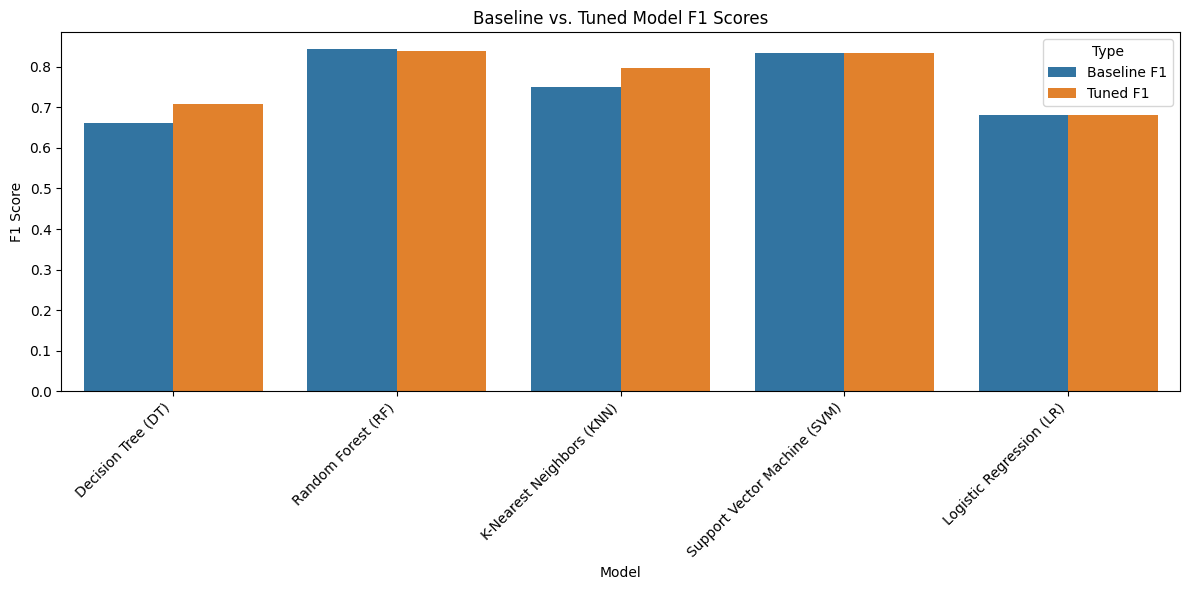

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score', hue='Type', data=plot_df_melted)
plt.title('Baseline vs. Tuned Model F1 Scores')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()